In [2]:
%load_ext autoreload
%autoreload 2

## Objective

Let's run a Linear Regression model with only one feature, as our baseline.

In [3]:
import os, sys
sys.path.append(os.path.join(os.path.dirname('.'), "../preprocessing"))

from transform_for_num_issues_pred import main as transform_dataset

In [4]:
from __future__ import division
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning)
sns.set_style("whitegrid")
sns.set_context("poster")
rcParams['figure.figsize'] = 20, 5

from helper_functions import dummify_cols_and_baselines, make_alphas, adjusted_r2, transform_school

In [5]:
df_orig = pd.read_pickle('../data/data_from_remove_from_dataset.pkl')
df_orig.shape

(516406, 40)

In [6]:
df_orig = transform_school(df_orig)
df_orig.shape

../preprocessing/helper_functions.py:58: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  df.school = df.school.str.extract(r'(\d\d?)').astype(int)


(516406, 40)

In [7]:
df_orig.head(1).T

,905425
CASE_ENQUIRY_ID,101001983786
OPEN_DT,2017-01-07 10:51:37
CLOSED_DT,2017-01-07 11:46:43
TYPE,Request for Snow Plowing
SubmittedPhoto,True
LOCATION_ZIPCODE,2124
Property_Type,Address
LATITUDE,42.2809
LONGITUDE,-71.068
Source,Citizens Connect App


In [8]:
df_transformed = transform_dataset(df_orig)
df_transformed.shape

../preprocessing/transform_for_num_issues_pred.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_subset['NUM_ISSUES'] = 1


(534, 28)

In [9]:
df_transformed.NUM_ISSUES_PER_1000_POP.describe()

count     534.000000
mean      816.807870
std       397.501518
min        36.706869
25%       569.713779
50%       765.916847
75%      1029.902627
max      2939.597315
Name: NUM_ISSUES_PER_1000_POP, dtype: float64

In [10]:
df_transformed.set_index('tract_and_block_group').NUM_ISSUES_PER_1000_POP.sort_values(ascending=False).head(10)

tract_and_block_group
0107021    2939.597315
0404012    2247.452693
0201011    2224.089636
0701011    2094.106464
0703002    2070.548712
0403005    2040.268456
0806013    2038.740920
0703001    1924.330617
0002012    1901.960784
0910013    1847.953216
Name: NUM_ISSUES_PER_1000_POP, dtype: float64

## Dropping more outliers

To see if that improves the model. If so, the next question is, when do we stop removing outliers!?!

In [13]:
more_outliers = ['0107021', '0701011', '0806013'] # last one is Dudley

In [14]:
df_transformed = df_transformed[~df_transformed.tract_and_block_group.isin(more_outliers)]
df_transformed.shape

(531, 28)

In [15]:
df_transformed.head(1).T

,0
tract_and_block_group,1004002
race_white,0.242399
race_black,0.514358
race_asian,0.035473
race_hispanic,0.0675676
race_other,0.140203
poverty_pop_below_poverty_level,0
earned_income_per_capita,34340
poverty_pop_w_public_assistance,0.0597484
poverty_pop_w_food_stamps,0.138365


## Choosing columns

Income performs better than house value.

In [16]:
cols_orig_dataset = ['NUM_ISSUES_PER_1000_POP']
cols_census = ['income']

In [17]:
df_col_subset = df_transformed[cols_orig_dataset + cols_census]
df_col_subset.shape

(531, 2)

## Dummify

In [18]:
cols_to_dummify = df_col_subset.dtypes[df_col_subset.dtypes == object].index
cols_to_dummify

Index([], dtype='object')

In [19]:
df_dummified, baseline_cols = dummify_cols_and_baselines(df_col_subset, cols_to_dummify)

In [20]:
df_dummified.shape

(531, 2)

In [21]:
# df_dummified = df_dummified.drop('race_other', axis=1)

## Quick viz

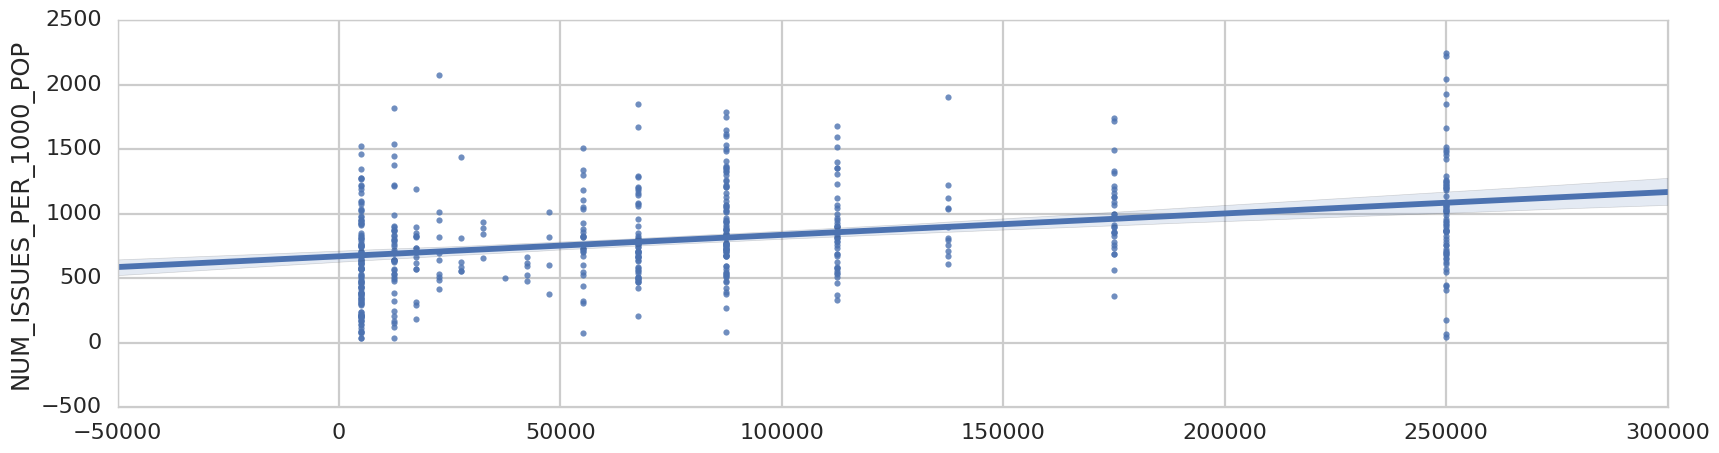

In [22]:
sns.regplot(    df_dummified.drop('NUM_ISSUES_PER_1000_POP', axis=1), 
    df_dummified.NUM_ISSUES_PER_1000_POP)

## Running model

In [14]:
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.cross_validation import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import make_scorer


/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    df_dummified.drop('NUM_ISSUES_PER_1000_POP', axis=1), 
    df_dummified.NUM_ISSUES_PER_1000_POP, 
    test_size=0.2, 
    random_state=500
)

In [63]:
pipe = make_pipeline(StandardScaler(), LassoCV())

In [17]:
mse = make_scorer(mean_squared_error, greater_is_better=False)
adjusted_r2_scorer = make_scorer(adjusted_r2, num_features=X_test.shape[1])

In [64]:
params = {'lassocv__alphas': make_alphas(-5, 3)}
# params = {'lassocv__alphas': [[0.1], [0.3], [1]]}
model = GridSearchCV(pipe, param_grid=params, n_jobs=-1, cv=10, scoring=adjusted_r2_scorer)
model.fit(X_train, y_train);

In [65]:
pd.DataFrame(model.cv_results_).T.iloc[:5]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
mean_fit_time,0.039738,0.0334662,0.0393897,0.0306926,0.0364546,0.0332345,0.0345163,0.0281769,0.0375175,0.0379262,0.0302372,0.0330773,0.0335913,0.0337993,0.0339366,0.0291906,0.0237981
mean_score_time,0.00223811,0.000793624,0.000780463,0.000786543,0.000792885,0.00201912,0.000768232,0.000772119,0.00077877,0.00318537,0.000789189,0.000785565,0.000766349,0.000779486,0.000783896,0.0010577,0.000676703
mean_test_score,0.0456085,0.0456085,0.0456085,0.0456085,0.0456086,0.0456089,0.0456098,0.0456123,0.0456212,0.0456463,0.0457291,0.045924,0.0461184,0.0424932,-0.018967,-0.0621853,-0.0621853
mean_train_score,0.110402,0.110402,0.110402,0.110402,0.110402,0.110402,0.110402,0.110402,0.110402,0.110402,0.110396,0.110341,0.10972,0.104262,0.0421772,-0.00262813,-0.00262813
param_lassocv__alphas,[1e-05],[3e-05],[0.0001],[0.0003],[0.001],[0.003],[0.01],[0.03],[0.1],[0.3],[1.0],[3.0],[10.0],[30.0],[100.0],[300.0],[1000.0]


In [66]:
print model.best_score_
print model.best_params_

0.04611837011
{'lassocv__alphas': [10.0]}


In [67]:
model.score(X_test, y_test)

0.1183831982643103

In [68]:
y_pred = model.predict(X_test)

In [69]:
r2_score(y_test, y_pred)

0.12670033790332624

In [70]:
mean_squared_error(y_test, y_pred)**0.5

355.82405307872625

## Conclusion

Our baseline model's performance has adjusted $R^2=0.13$.